<a href="https://colab.research.google.com/github/OrangeAoo/AI/blob/main/GenAI-NLP/ToyCodes/Homework%202/Text_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Generation: GPT2 and Story Generation

## Introduction

In this notebook, we demo
- what is the architecture of GPT2
- How each token is generated in the inference stage

In order to do so, we demo how to train a GPT2-like model for writting little stories.

Install Package

In [ ]:
!pip install pytorch-lightning
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.5 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatibl

## Read in the data

We first download the dataset from Huggingface

In [ ]:
from datasets import load_dataset

# Load the dataset and shuffle it
dataset = load_dataset("mintujupally/ROCStories", split='train', streaming=True)

# Take the first 100 examples

#small_dataset = dataset.take(10000)

# Convert the dataset to a list of dictionaries to download
examples = list(dataset)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/256 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


Take a look for the relevant columns, where `text` is the column of the little stories.

In [ ]:
import pandas as pd
df = pd.DataFrame(examples)
df

,text
0,The boy went to a video arcade. He played his ...
1,"Jimmy was a big fan of cricket. In summer, his..."
2,The baby shook from the cold room. His mother ...
3,Luke didn't want to pay 15 dollars for a movie...
4,Kara was very close to her mother when she was...
...,...
78523,Will left the living room while his daughter w...
78524,My friend introduced me to a close friend of h...
78525,Kelly had a black kitten when she was younger....
78526,Starting my first day of college was terrifyin...


Take a look for an example

In [ ]:
df['text'][0]

"The boy went to a video arcade. He played his favorite machine. His games didn't go very well. He told the owner about his experience. The owner explained that he had made the game settings harder."

Split the dataset into train and text data using `train_test_split` from `sklearn`.

In [ ]:
from sklearn.model_selection import train_test_split

texts = df['text'].to_list()

train_texts, test_texts = train_test_split(texts, test_size=.2, random_state=42)

In [ ]:
len(train_texts), len(test_texts) # the size of train vs test

(62822, 15706)

## Build the GPT2-like model

### Tokenization
To begin, we need a tokenizer that can map a text to a sequence of integers (and vice-versa).

Here we are going to borrow the tokenizer from `GPT2` directly.

Download the tokenizer (one line of code thanks to Huggingface).

In [ ]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained('gpt2-large')

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Encode a text and obtain a sequence of integers, each integer is called a `token`.

In [ ]:
tokenizer.encode('hello world', return_tensors='pt')

tensor([[31373,   995]])

### Model Architecture


The difference between Transformer we talked last lecture and the Text-generation Transformer here is the `causal_mask`.

The causal mask (hence the Causal Attention Layer) prevents the tokens access information from future tokens.

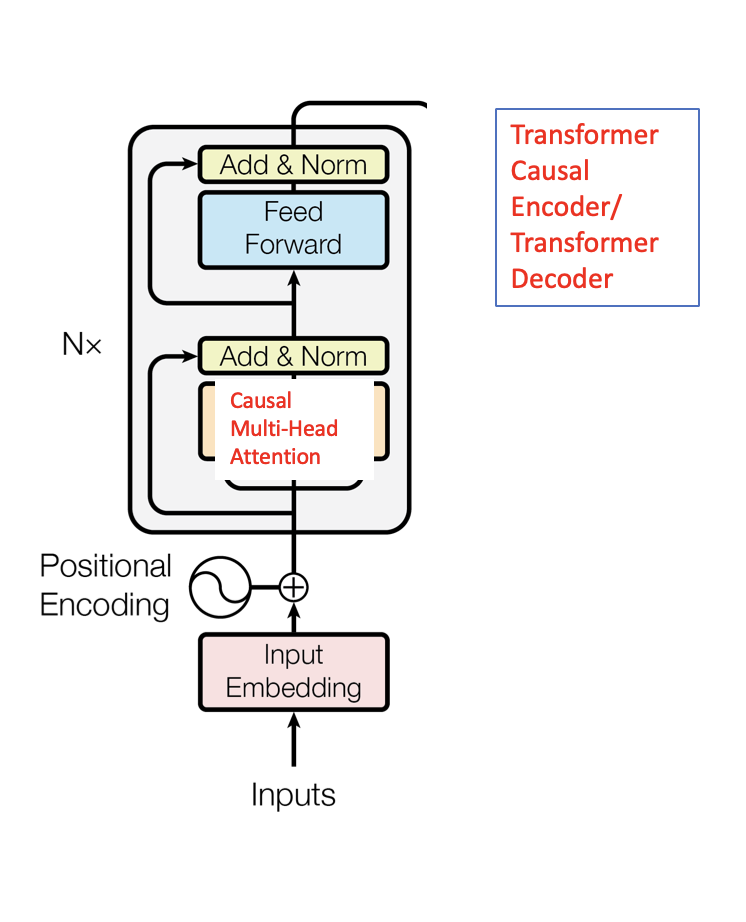

We start by writing down a function that creates causal mask. a `True` value indicates that the corresponding position is not allowed to attend

In [ ]:
import torch
import torch.nn as nn
import transformers.activations as activations

def generate_square_subsequent_mask(seq_len):
    mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool()
    return mask

generate_square_subsequent_mask(100)

tensor([[False,  True,  True,  ...,  True,  True,  True],
        [False, False,  True,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        ...,
        [False, False, False,  ..., False,  True,  True],
        [False, False, False,  ..., False, False,  True],
        [False, False, False,  ..., False, False, False]])

We implement a GPT2-like structure here:

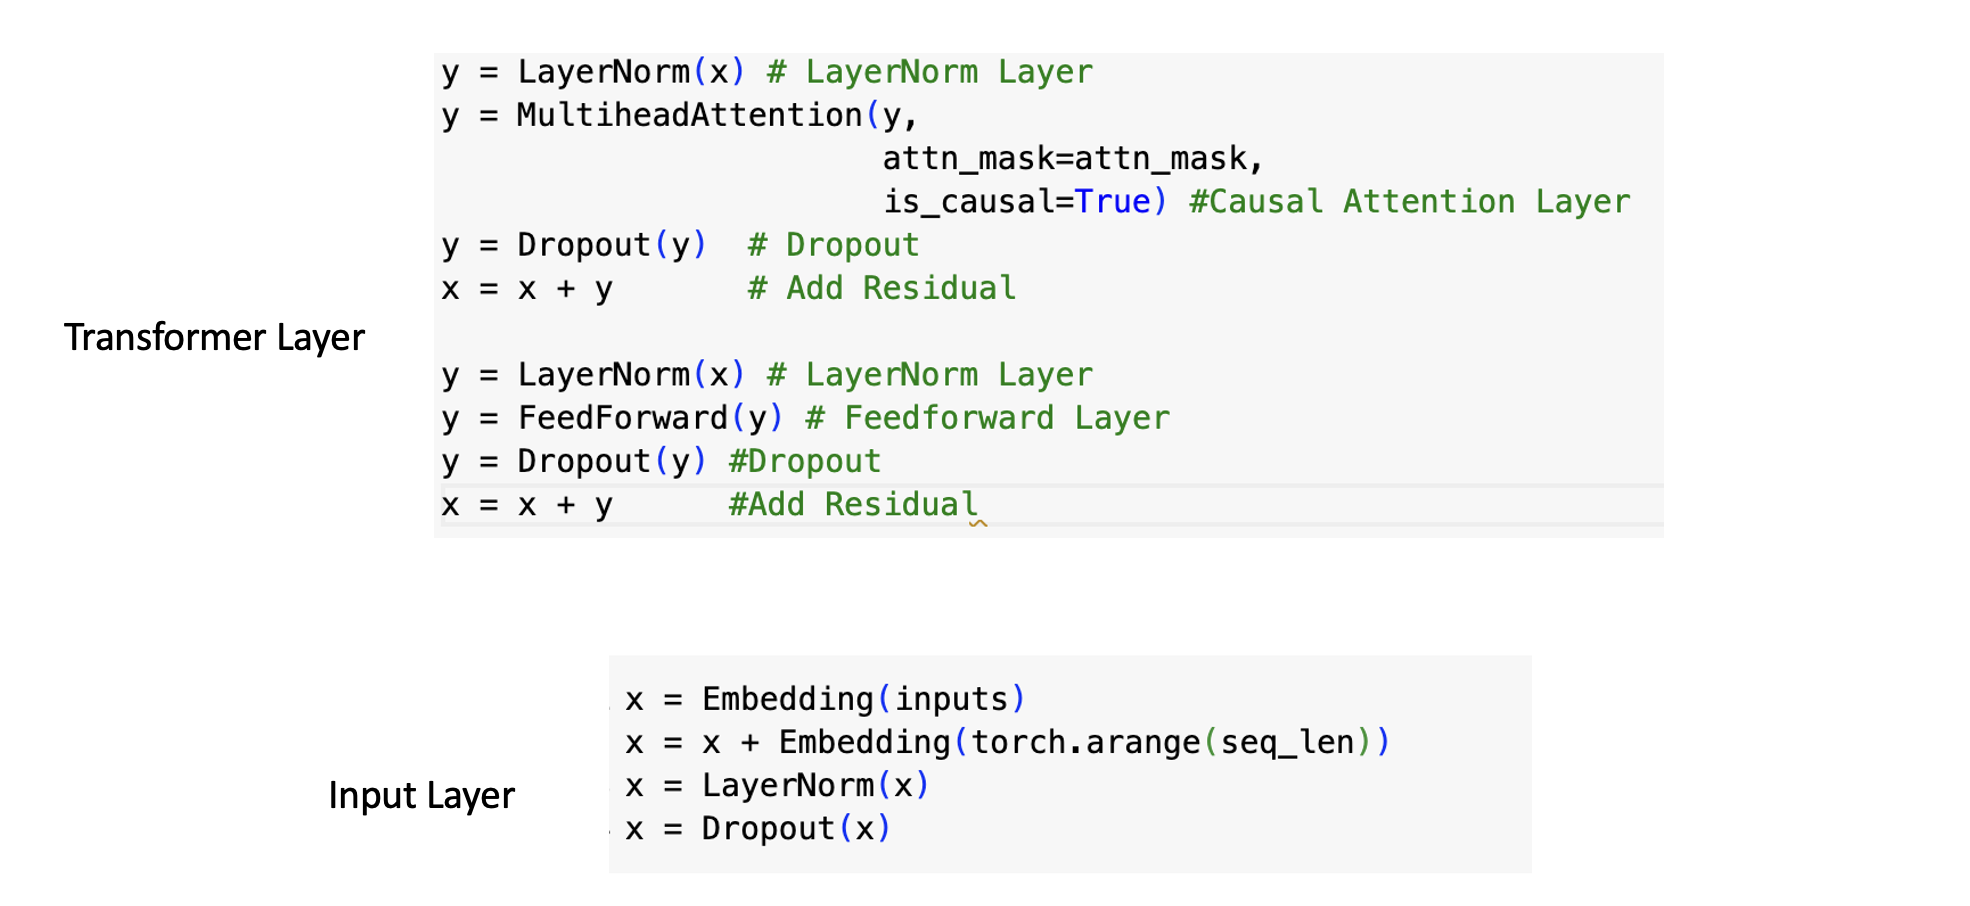

Compare to the traditional Attention, GPT2 add `Causal Attention Mask` and change the order of LayerNorm slighly.

In [ ]:
class TransformerLayer(nn.Module):
    def __init__(self, embedding_dim, num_heads, dropout=0.1):
        super().__init__()
        self.attention = nn.MultiheadAttention(embedding_dim, num_heads, dropout=dropout, batch_first=True)
        self.feed_forward = nn.Sequential(
            nn.Linear(embedding_dim, 4 * embedding_dim),
            activations.NewGELUActivation(),
            nn.Linear(4 * embedding_dim, embedding_dim),
        )
        self.dropout = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(embedding_dim)
        self.norm2 = nn.LayerNorm(embedding_dim)

    def forward(self, x):
        ## dimension of x is [batch_size, sequence_length, embedding_dim]
        y = self.norm1(x)
        seq_len = x.size(1)
        attn_mask = generate_square_subsequent_mask(seq_len).to(x.device)
        attention_output = self.attention(y, y, y, attn_mask=attn_mask, is_causal=True)[0]
        x = x + self.dropout(attention_output)
        x = x + self.dropout(self.feed_forward(self.norm2(x)))
        return x

class Transformer(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_heads, num_layers, max_seq_len, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.pos_embedding = nn.Embedding(max_seq_len, embedding_dim)
        self.dropout = nn.Dropout(dropout)
        self.transformer_layers = nn.ModuleList([TransformerLayer(embedding_dim, num_heads) for _ in range(num_layers)])
        self.ln_f = nn.LayerNorm(embedding_dim)

    def forward(self, inputs):
        # dimension of inputs is [batch_size, sequence_length]
        x = self.embedding(inputs)
        pos_embedding = self.pos_embedding(torch.arange(inputs.size(1), device=inputs.device))
        x = x + pos_embedding
        x = self.dropout(x) # dimension of x is [batch_size, sequence_length, embedding_dim]
        for layer in self.transformer_layers:
            x = layer(x)
        x = self.ln_f(x)
        return x

Can you add forward function for the Transformer Head for Token Generation?

In [ ]:

class CausalLMTransformer(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_heads, num_layers, max_seq_len):
        super().__init__()
        self.base_model = Transformer(vocab_size, embedding_dim, num_heads, num_layers, max_seq_len)
        self.lm_head = nn.Linear(embedding_dim, vocab_size, bias=False)
        self.lm_head.weight = self.base_model.embedding.weight # GPT2 used the same weights for encoding embedding and decoding embedding

    def forward(self, input_ids, attention_mask):
        x = self.base_model(input_ids)
        logits = self.lm_head(x)
        return logits


max_seq_len = 1024
embedding_dim = 1280
num_heads = 20
num_layers = 12
model = CausalLMTransformer(tokenizer.vocab_size, embedding_dim, num_heads, num_layers, max_seq_len)

How many parameters for this model?

Hypothetically if we change

`max_seq_len=2048`

`embedding_dim=12288`

`num_heads=96`

`num_layers=96`

How many parameters would the model have? (This is in fact the configuration of GPT3!)

You can test that whether the output dimension is what we want. The shape should be [1, 2, 50257]

In [ ]:
input = tokenizer('hello world', return_tensors='pt')
model(**input).shape

torch.Size([1, 2, 50257])

Next we want to write a decoding function for generating tokens

 let's download the GPT2-large model

In [ ]:
from transformers import AutoModelForCausalLM

GPT2 = AutoModelForCausalLM.from_pretrained('gpt2-large')

In [ ]:
### greedy_decode

import torch
import numpy as np

# Define the function for greedy decoding
def greedy_decode(model, tokenizer, input_text, max_length=50, temperature=1):

    np.random.seed(42)
    torch.manual_seed(42)
    # Set the model to evaluation mode
    model.eval()

    # Tokenize the input text
    input_ids = tokenizer.encode(input_text, return_tensors="pt")


    if torch.cuda.is_available():
        model.to('cuda')
        input_ids = input_ids.to('cuda')

    # Initialize the generated sequence with the input_ids
    generated_ids = input_ids


    # Loop to generate the sequence token by token
    for _ in range(max_length):
        # Get model predictions for the current generated_ids

        outputs = model(generated_ids, attention_mask=torch.ones_like(generated_ids, device=generated_ids.device))

        # Get the logits for the last token in the generated sequence
        if isinstance(outputs, torch.Tensor):
            next_token_logits = outputs[:, -1, :]
        else:
            next_token_logits = outputs.logits[:, -1, :]

        # Select the token with the highest probability (greedy approach)

        #next_token_id = torch.argmax(next_token_logits, dim=-1).unsqueeze(0)


        # Convert logits to probabilities
        probabilities = torch.softmax(next_token_logits / temperature, dim=-1)

        # Sample the next token from the probability distribution
        next_token_id = torch.multinomial(probabilities, num_samples=1)

        # Append the predicted token id to the generated sequence
        generated_ids = torch.cat((generated_ids, next_token_id), dim=1)

        # If the generated token is the end-of-sequence token, stop generating
        if next_token_id.item() == tokenizer.eos_token_id:
            break

    #print(generated_ids)

    # Decode the generated sequence of token ids back to text
    generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    model.to('cpu')
    return generated_text


# let's test whether the decoder works
input_text = "We are attending an AI class right now."
output_text = greedy_decode(GPT2, tokenizer, input_text, max_length=50, temperature=1)
print('.\n'.join(output_text.split('.')))

We are attending an AI class right now.
 He has no idea who I am, and had never talked to me before.
" she said, "One minute he says all AIs are divided and one is always privileged, and the next minute he says *I'm* speaking for the majority!"


Try small temperature, so the output is most deterministic

In [ ]:
# Example usage
input_text = "We are attending an AI class right now."
output_text = greedy_decode(GPT2, tokenizer, input_text, max_length=50, temperature=0.0001)
print('.\n'.join(output_text.split('.')))

We are attending an AI class right now.
 I'm a bit nervous, but I'm excited to learn more about the technology.
 I'm also curious about how it will affect the world.


I'm also curious about how it will affect the world.


I'm also curious about


Play with the temperature

In [ ]:
# Example usage
input_text = "We are attending an AI class right now."
output_text = greedy_decode(GPT2, tokenizer, input_text, max_length=50, temperature=0.4)
print('.\n'.join(output_text.split('.')))

We are attending an AI class right now.
 It's a class on Artificial Intelligence, and it's a class on the topic of human-level AI.
 The professor is a very smart guy, and he's not a big fan of AI.
 He says, "I'm not interested in AI


## Training

A helper function for training the model

In [ ]:

from torch.utils.data import DataLoader
tokenizer.pad_token = tokenizer.eos_token # GPT2 was trained on non-padding data, here we set a padding token as the end-of-sequence token

def collate_fn(batch):
    texts = batch
    texts = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=max_seq_len)
    labels = texts['input_ids'][:, 1:].clone()
    return texts, labels

tokenizer.pad_token = tokenizer.eos_token
batch_size = 4
train_dataloader = DataLoader(train_texts, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=4)
test_dataloader = DataLoader(test_texts, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=4)

We are going to be a little bit more professional now of using Weight&Bias for monitoring training.

In [ ]:
!pip install wandb



You need to create an account for [Weight&Bias](https://wandb.ai/) if you don't have one already.

Copy your API key from https://wandb.ai/authorize to login for the following code block.

W&B provides a nice platform for you to monitor your loss while training.

In [ ]:
import wandb

wandb.login()


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

Before training, we are hacking a bit here by loading weights from GPT2-large for the first 12 layers (since we only have little data and training from scratch will not be sufficient). In addition, GPT2-large has 36 layers so we are not cheating.

In Problem 2, you would need to remove this weight loading from GPT2-large and run the whole notebook

In [ ]:
### load GPT2 weight to model
### copy the weight data
model.base_model.embedding.weight.data = GPT2.transformer.wte.weight.detach().clone()
model.lm_head.weight.data = GPT2.lm_head.weight.detach().clone()
model.base_model.pos_embedding.weight.data = GPT2.transformer.wpe.weight.detach().clone()
model.base_model.ln_f.weight.data = GPT2.transformer.ln_f.weight.detach().clone()
model.base_model.ln_f.bias.data = GPT2.transformer.ln_f.bias.detach().clone()
for i in range(num_layers):
    model.base_model.transformer_layers[i].attention.in_proj_weight.data = GPT2.transformer.h[i].attn.c_attn.weight.data.T.detach().clone()
    model.base_model.transformer_layers[i].attention.in_proj_bias.data = GPT2.transformer.h[i].attn.c_attn.bias.data.detach().clone()
    model.base_model.transformer_layers[i].attention.out_proj.weight.data = GPT2.transformer.h[i].attn.c_proj.weight.data.T.detach().clone()
    model.base_model.transformer_layers[i].attention.out_proj.bias.data = GPT2.transformer.h[i].attn.c_proj.bias.data.detach().clone()
    model.base_model.transformer_layers[i].norm1.weight.data = GPT2.transformer.h[i].ln_1.weight.data.detach().clone()
    model.base_model.transformer_layers[i].norm1.bias.data = GPT2.transformer.h[i].ln_1.bias.data.detach().clone()
    model.base_model.transformer_layers[i].norm2.weight.data = GPT2.transformer.h[i].ln_2.weight.data.detach().clone()
    model.base_model.transformer_layers[i].norm2.bias.data = GPT2.transformer.h[i].ln_2.bias.data.detach().clone()
    model.base_model.transformer_layers[i].feed_forward[0].weight.data = GPT2.transformer.h[i].mlp.c_fc.weight.data.T.detach().clone()
    model.base_model.transformer_layers[i].feed_forward[2].weight.data = GPT2.transformer.h[i].mlp.c_proj.weight.data.T.detach().clone()
    model.base_model.transformer_layers[i].feed_forward[0].bias.data = GPT2.transformer.h[i].mlp.c_fc.bias.data.detach().clone()
    model.base_model.transformer_layers[i].feed_forward[2].bias.data = GPT2.transformer.h[i].mlp.c_proj.bias.data.detach().clone()

Before training, let's take a look for the output (it is purely random!)

In [ ]:
# Example usage
input_text = "We are attending an AI class right now."
output_text = greedy_decode(model, tokenizer, input_text, max_length=50)
print('.\n'.join(output_text.split('.')))

We are attending an AI class right now.
 Heinerthistle protagonist thinning surrealistically realisticsuspect mode ethereumthereum bullswhomsoeverahuasca ritualistic revivalism turcuntainskgsmavern stall class complete seminality * Photographer from high school graduation secured a massive


Let's kick off the training. You can visit the url below to Weight&Bias and see your training curve: for example

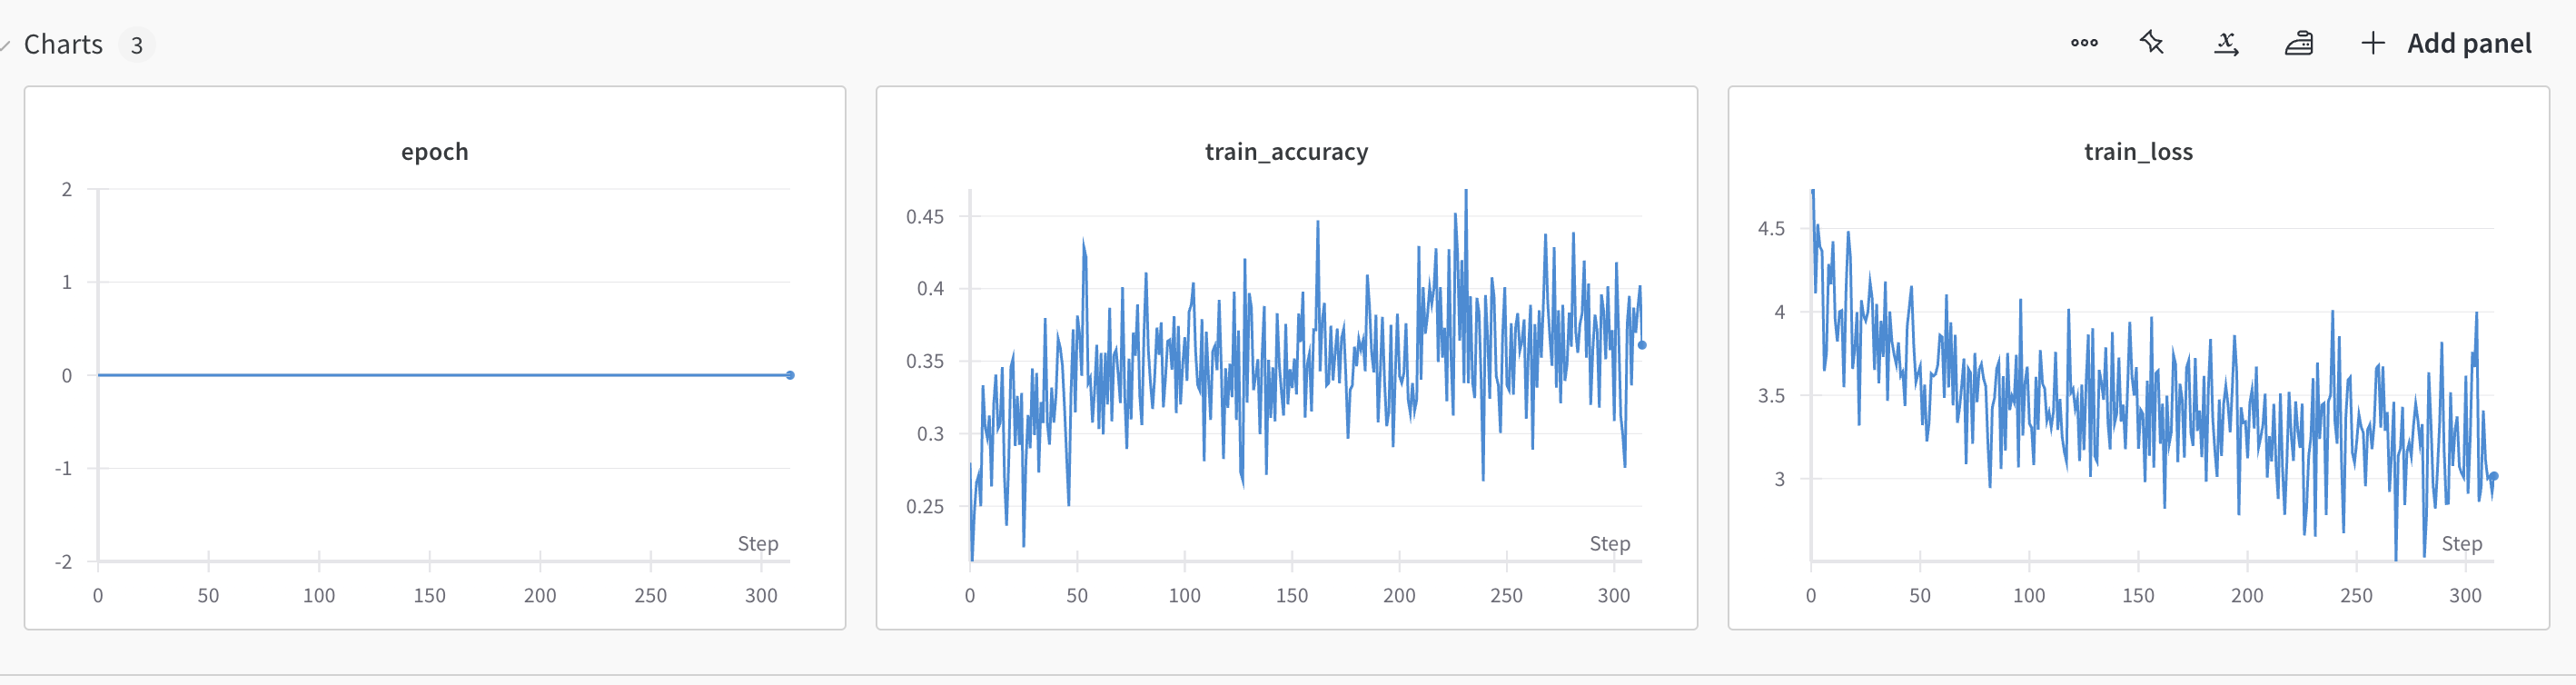

In [ ]:
import pytorch_lightning as pl
from torch.optim import AdamW
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import time


class CausalLMModule(pl.LightningModule):
    def __init__(self, model, loss_fn):
        super().__init__()
        self.model = model
        self.loss_fn = loss_fn

        self.val_accuracy = 0
        self.total_batch = 0

    def concatenation_processs(self, texts, logits, labels):
        valid_lengths = texts['attention_mask'].sum(dim=1)  # Calculate the valid lengths for each sequence in the batch
        concatenated_logits = [logits[i, :valid_lengths[i] - 1] for i in range(logits.size(0))]
        concatenated_logits = torch.cat(concatenated_logits, dim=0)

        concatenated_labels = [labels[i, :valid_lengths[i] - 1] for i in range(labels.size(0))]
        concatenated_labels = torch.cat(concatenated_labels, dim=0)
        logits = concatenated_logits
        labels = concatenated_labels
        return logits, labels

    def training_step(self, batch, batch_idx):
        texts, labels = batch
        logits = self.model(**texts)
        if not isinstance(logits, torch.Tensor):
            logits = logits.logits
        logits, labels = self.concatenation_processs(texts, logits, labels)
        loss = self.loss_fn(logits, labels)
        #Calculate accuracy
        preds = logits.argmax(dim=1)
        accuracy = (preds == labels).float().mean()
        #Log loss and accuracy
        self.log('train_loss', loss)
        self.log('train_accuracy', accuracy)
        return loss

    def validation_step(self, batch, batch_idx):
        texts, labels = batch
        logits = self.model(**texts)
        if not isinstance(logits, torch.Tensor):
            logits = logits.logits
        logits, labels = self.concatenation_processs(texts, logits, labels)

        # Calculate loss
        loss = self.loss_fn(logits, labels)
        # Calculate accuracy
        preds = logits.argmax(dim=1)
        accuracy = (preds == labels).float().mean()
        # Log loss and accuracy
        self.log('val_loss', loss, on_step=True, on_epoch=True)
        self.log('val_accuracy', accuracy, on_step=True, on_epoch=True)
        self.val_accuracy += accuracy.item()
        self.total_batch += 1
        return loss

    def on_validation_epoch_end(self):
        print('val_accuracy', self.val_accuracy / self.total_batch)
        self.val_accuracy = 0
        self.total_batch = 0

    def configure_optimizers(self):
        return AdamW(model.parameters(), lr=1e-5)

### run training
num_epochs = 1
csv_logger = CSVLogger('logs', name='my_model')
wandb.finish(quiet=True)
wandb_logger = WandbLogger(project="text-story-generation-new", name ='model_' + time.strftime("%Y-%m-%d_%H-%M-%S"))
print(wandb_logger.name)


trainer = pl.Trainer(logger=wandb_logger,
                     max_epochs=num_epochs,
                     precision='16-mixed'
                     )

loss_fn = nn.CrossEntropyLoss()
train_module = CausalLMModule(model, loss_fn)

trainer.fit(train_module, train_dataloader, test_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


text-story-generation-new


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | CausalLMTransformer | 301 M  | eval 
1 | loss_fn | CrossEntropyLoss    | 0      | train
--------------------------------------------------------
301 M     Trainable params
0         Non-trainable params
301 M     Total params
1,207.086 Total estimated model params size (MB)
1         Modules in train mode
128       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

val_accuracy 0.0690968856215477


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

val_accuracy 0.3738908799953791


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


The following function will validate your model on test dataset

In [ ]:
trainer.validate(train_module, test_dataloader)


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

val_accuracy 0.3738908799953791


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    val_accuracy_epoch     │    0.37388449907302856    │
│      val_loss_epoch       │     3.205319404602051     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss_epoch': 3.205319404602051,
  'val_accuracy_epoch': 0.37388449907302856}]

The following code will validate GPT2-large on the test dataset. We see GPT2-large is slightly better since it has 36 layers and our model only has 12 layers (still not bad, we achieve a similar performance with 1/3 parameters).

In [ ]:

train_module_GPT2 = CausalLMModule(GPT2, loss_fn)
trainer.validate(train_module_GPT2, test_dataloader)


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

val_accuracy 0.3875205390988217


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    val_accuracy_epoch     │    0.38752299547195435    │
│      val_loss_epoch       │     2.961885929107666     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss_epoch': 2.961885929107666,
  'val_accuracy_epoch': 0.38752299547195435}]

Test a few examples. The logic does not flow yet but the model behaves much better now than a random guess.

In [ ]:
input_text = "Zach was volunteering at a festival."
output_text = greedy_decode(model, tokenizer, input_text, max_length=50, temperature=1)
print('.\n'.join(output_text.split('.')))

Zach was volunteering at a festival.
 He was really excited to receive his ticket.
 On the day of the event he picked up his ticket.
 He booked a concert at the event.
 Zach knew he wanted to watch some sports on his vocals.
 Zach felt much better and he secured a tournament


In [ ]:
input_text = "We are attending an AI class right now."
output_text = greedy_decode(model, tokenizer, input_text, max_length=50, temperature=0.9)
print('.\n'.join(output_text.split('.')))

We are attending an AI class right now.
 He has been taking a test in preparation for a week.
 When I was in class, I drew a map to Continent of Auctured.
 My errands always not work in class.
 Everything is great, so I hope I will pass it.

